# Full workflow

This notebook outlines a complete ramannoodle workflow and is, as always, available on [Github](https://github.com/wolearyc/ramannoodle/blob/main/docs/source/notebooks/full-workflow.ipynb).  

Here, we will use [ARTModel](../generated/ramannoodle.pmodel.html#module-ramannoodle.pmodel.art.ARTModel), a flavor of [InterpolationModel](../generated/ramannoodle.pmodel.html#module-ramannoodle.pmodel.interpolation.InterpolationModel), to again calculate TiO2's Raman spectrum. ARTModel uses "atomic Raman tensors" to predict polarizabilities, but is ultimately an InterpolationModel where

1. All degrees of freedom (DOFs) are single atom displacements.
2. All interpolations are first-order.
3. Only two polarizabilities are used to construct each interpolation.

Under these conditions, we dub each DOF polarizability interpolation (or more precisely, the derivative of the interpolation) as an **atomic Raman tensor**, or ART.

Although [ARTModel](../generated/ramannoodle.pmodel.html#module-ramannoodle.pmodel.art.ARTModel) dictates that each DOF is a single atom displacement, we are free to choose the three orthogonal directions of the atom displacements. This means there are an infinite number of valid DOFs! Ultimately, the chosen atomic DOFs depends on user preference as well as the research question at hand. Still, wise choice of atomic DOFs can significantly reduce the cost of Raman calculations. 

Regardless of how we choose our DOFs, we want to be sure that our DOFs are **valid** before carrying out expensive polarizability calculations and feeding the results into [ARTModel](../generated/ramannoodle.pmodel.html#module-ramannoodle.pmodel.art.ARTModel). To check our DOFs, we use **dummy models**. Essentially, we will build up a polarizability model in the usual way, except we instruct the model to internally generate "dummy polarizabilities". Although a dummy model cannot be used to predict polarizabilities (and therefore cannot be used to compute Raman spectra), it allows us to perform a dry run before we expend our valuable computational resources.

We'll begin with some imports and some customizations to matplotlib. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

### Setup of dummy model

Our final goal is to calculate TiO2's Raman spectrum. As in the [basic tutorial](../notebooks/basics.html), we will start by reading in a reference structure. 

In [2]:
import ramannoodle.io.vasp as vasp_io

data_dir = "../../../test/data/TiO2"
ref_structure = vasp_io.poscar.read_ref_structure(f"{data_dir}/POSCAR")


Now that we have the reference structure, we can initialize the polarizability model. We do this the usual way, but we specify `is_dummy_model = True`. Because this is a dummy model, the value for `ref_polarizability` is completely ignored. We simply set it to ``np.zeros((3,3))``. 

In [3]:
from ramannoodle.pmodel.art import ARTModel

model = ARTModel(ref_structure=ref_structure, 
                 ref_polarizability = np.zeros((3,3)), 
                 is_dummy_model=True)               
model

╭──────────────┬──────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions   │ Specified   │   Equivalent atoms │
├──────────────┼──────────────┼─────────────┼────────────────────┤
│            0 │              │ 0/3         │                 35 │
│           36 │              │ 0/3         │                 71 │
╰──────────────┴──────────────┴─────────────┴────────────────────╯
  ATTENTION: this is a dummy model. 

Note that the `__repr__` string indicates that this is a dummy model. In addition, we see that there are two symmetrically distinct atoms: a Ti (at index 0) and an O (at index 36). In this structure, all Ti atoms are equivalent to one another as are all oxygens. Our task is therefore to compute and add DOFs for a single Ti atom and a single O atom. Ramannoodle will use symmetry to derive the remaining DOFs, at which point the model is fully specified. 

### Specifying candidate displacements

For this example, we will choose atomic displacements along the x, y, and z directions as our DOFs. We first generate structures for these displacements then calculate the polarizabilities from first principles (in our case using VASP). To help set up these calculations, ramannoodle provides functions to write displaced structures in [ramannoodle.structure.displace](../generated/ramannoodle.structure.html#module-ramannoodle.structure.displace). Since we're using atomic Raman tensors, we will use [write_ast_displaced_structures](../generated/ramannoodle.structure.html#ramannoodle.structure.displace.write_ast_displaced_structures).

In [4]:
from ramannoodle.structure.displace import write_ast_displaced_structures

# Degrees of freedom (atomic Raman tensor) for one of the Ti atoms
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=4,
    cart_direction=np.array([1,0,0]), # x direction
    amplitudes = np.array([0.1]),     # -0.1 is symmetrically equivalent
    filepaths = ["Ti5_0.1x_eps_POSCAR"],
    file_format='poscar',
    overwrite=True
)
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=4,
    cart_direction=np.array([0,0,1]), # z direction
    amplitudes = np.array([0.1]),    # -0.1 is symmetrically equivalent
    filepaths = ["Ti5_0.1z_eps_POSCAR"],
    file_format='poscar',
    overwrite=True
)

# Degrees of freedom (atomic Raman tensor) for one of the O atoms
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=42,
    cart_direction=np.array([1,0,0]), # x direction
    amplitudes = np.array([0.1]),     # -0.1 is symmetrically equivalent
    filepaths = ["O43_0.1x_eps_POSCAR"],
    file_format='poscar',
    overwrite=True
)
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=42,
    cart_direction=np.array([0,1,0]), # y direction
    amplitudes = np.array([0.1]), # -0.1 is symmetrically equivalent
    filepaths = ["O43_0.1y_eps_POSCAR"],
    file_format='poscar',
    overwrite=True,
)
write_ast_displaced_structures(
    ref_structure=ref_structure,
    atom_index=42,
    cart_direction=np.array([0,0,1]), # z direction
    amplitudes = np.array([-0.1,0.1]), # these are unique
    filepaths = ["O43_m0.1z_eps_POSCAR","O43_0.1z_eps_POSCAR"], 
    file_format='poscar',
    overwrite=True
)

### Testing candidate displacements

We have chosen our displaced structures based on symmetry and written them to POSCARs. Before calculating polarizabilities with these POSCARs, however, we want to make sure that these displacements **cover all the DOFs of our system**. To do this, we build up our dummy model.

In [5]:
# Now we can add the outcars. Because we have a dummy model, ramannoodle will not look for polarizabilities in these files. Therefore, we could use OUTCARs from other calculations or (more commonly) use POSCARs.
model.add_art_from_files(
    ["Ti5_0.1x_eps_POSCAR"], file_format = 'poscar'
  )
model.add_art_from_files(
    ["Ti5_0.1z_eps_POSCAR"],file_format = 'poscar'
  )
model.add_art_from_files(
    ["O43_0.1z_eps_POSCAR", "O43_m0.1z_eps_POSCAR"], 
    file_format="poscar"
)
model.add_art_from_files(
    ["O43_0.1x_eps_POSCAR"], file_format = 'poscar'
)
model.add_art_from_files(["O43_0.1y_eps_POSCAR"],file_format = 'poscar')
model

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. +0. +1.], [+1. +0. +0.], [+0. +1. +0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯
  ATTENTION: this is a dummy model. 

Note that dummy polarizability models can be built up using files containing no polarizability data (such as POSCARs). 

All degrees of freedom have been specified. Clearly, we chose our DOFs wisely. Nice work! Just for kicks, what will happen if we try to compute a Raman spectrum with this dummy model?

In [6]:
# Compute and plot spectrum
phonons = vasp_io.outcar.read_phonons(f"{data_dir}/phonons_OUTCAR")
spectrum = phonons.get_raman_spectrum(model)
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(wavenumbers, total_intensities)

UsageError: dummy model cannot calculate polarizabilities

Since dummy models contain no polarizability information, they cannot be used to compute spectra! 

### Calculating a Raman spectrum

Now that we're sure our DOFs are valid, we carry out the polarizability calculations using VASP. We can then construct the real model, this time pointing to OUTCARs generated from these polarizability calculations.

In [7]:
_, ref_polarizability = vasp_io.outcar.read_positions_and_polarizability(
   f"{data_dir}/ref_eps_OUTCAR"
)
model = ARTModel(ref_structure=ref_structure, 
                 ref_polarizability = ref_polarizability)               

model.add_art_from_files(
    [f"{data_dir}/Ti5_0.1x_eps_OUTCAR"], file_format = 'outcar'
  )
model.add_art_from_files(
    [f"{data_dir}/Ti5_0.1z_eps_OUTCAR"],file_format = 'outcar'
  )
model.add_art_from_files(
    [f"{data_dir}/O43_0.1z_eps_OUTCAR", f"{data_dir}/O43_m0.1z_eps_OUTCAR"], 
    file_format="outcar"
)
model.add_art_from_files(
    [f"{data_dir}/O43_0.1x_eps_OUTCAR"], file_format = 'outcar'
)
model.add_art_from_files([f"{data_dir}/O43_0.1y_eps_OUTCAR"],file_format = 'outcar')
model

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. -0. +1.], [+1. -0. -0.], [+0. +1. -0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯

Now we calculate the Raman spectrum.

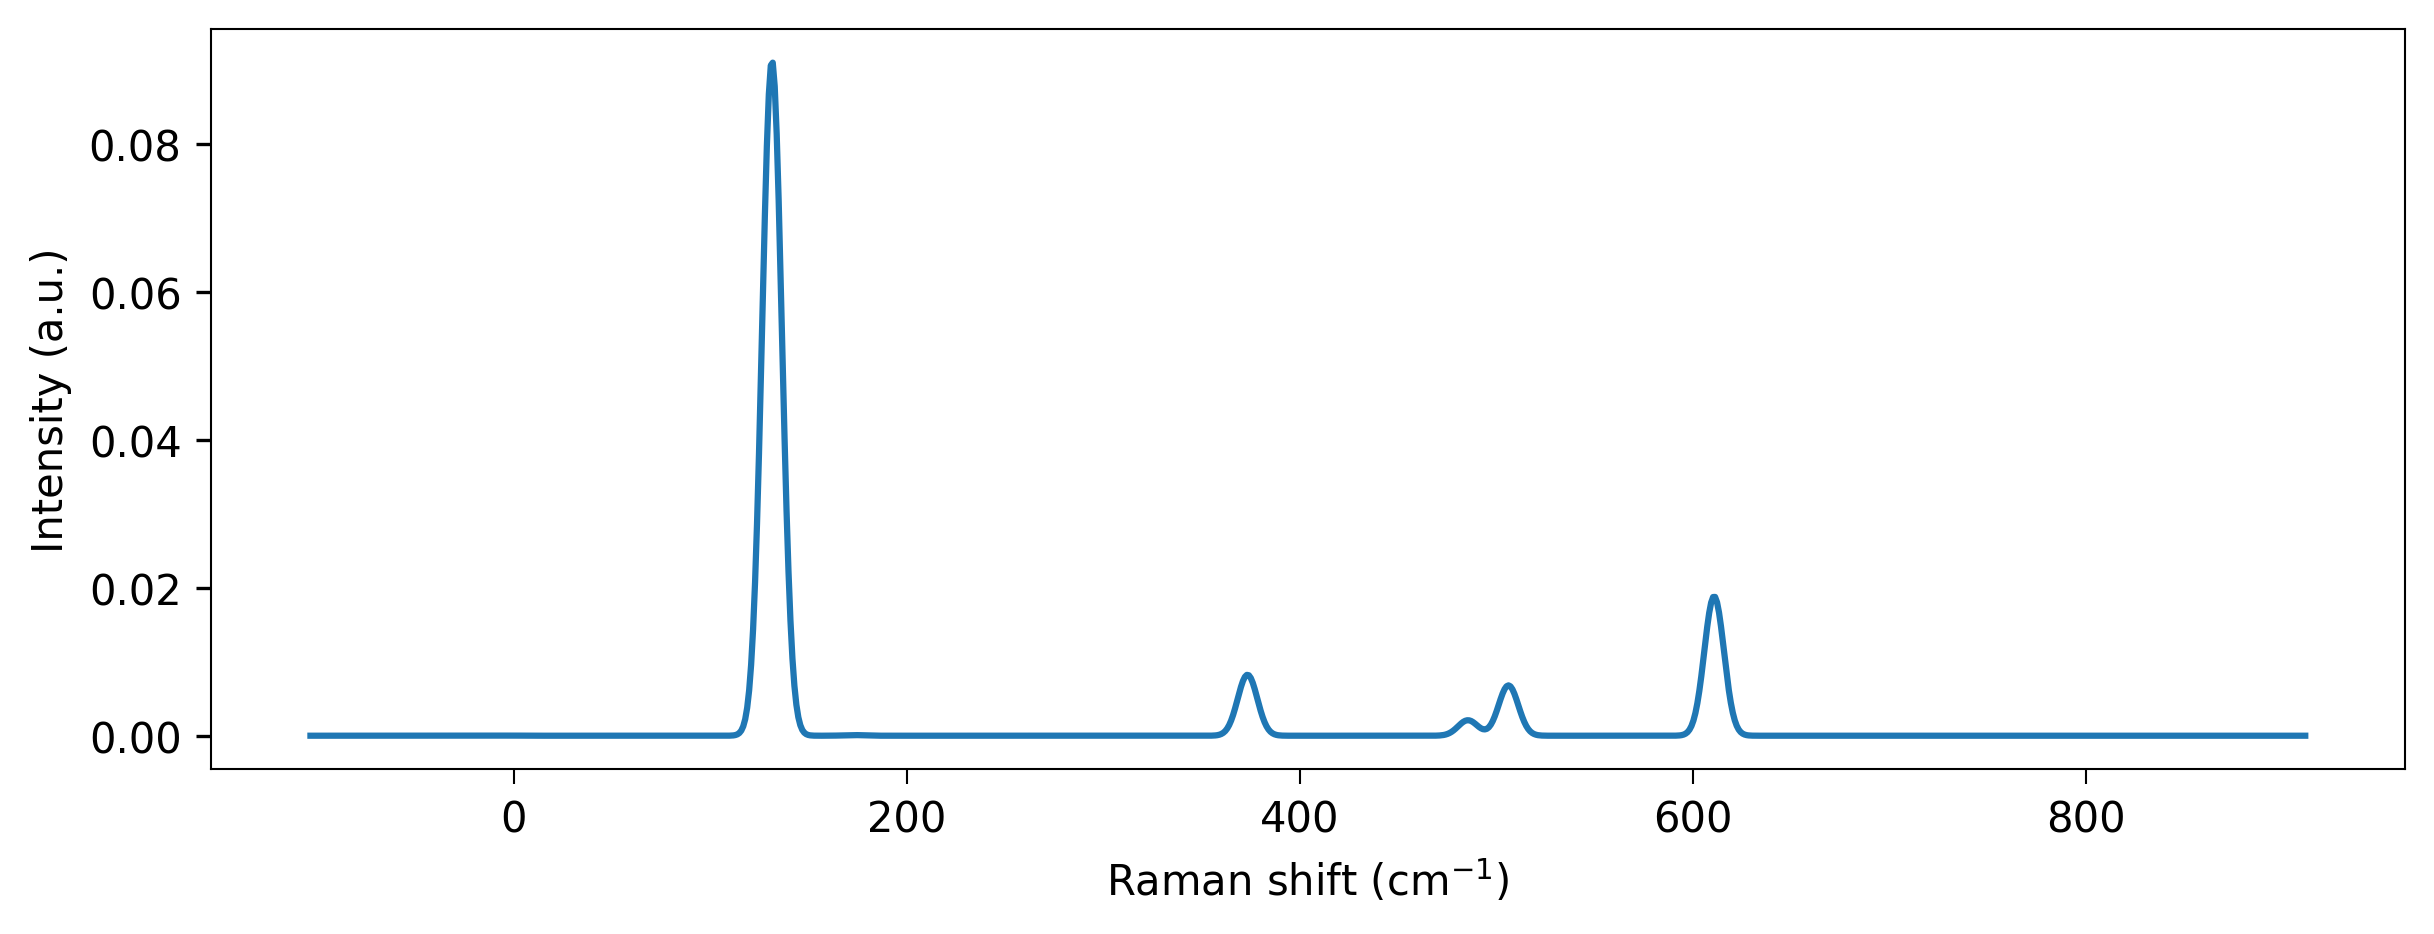

In [8]:
from ramannoodle.spectrum.spectrum_utils import convolve_spectrum

# Compute and plot spectrum
phonons = vasp_io.outcar.read_phonons(f"{data_dir}/phonons_OUTCAR")
spectrum = phonons.get_raman_spectrum(model)
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)

fig = plt.figure(constrained_layout = True, figsize = (8, 3))
axis = fig.add_subplot(111)
axis.plot(wavenumbers, total_intensities)
axis.set_ylabel("Intensity (a.u.)")
l = axis.set_xlabel(r"Raman shift ($\mathregular{cm^{-1}}$)")

Beautiful! 

So far, we have calculated phonon-based Raman spectra. Ramannoodle is also capable of calculating Raman spectra from molecular dynamics trajectories. This will be covered in the next tutorial: [Molecular dynamics](../notebooks/molecular-dynamics.html)